In [1]:
import wntr
from scripts_old.bundle_analysis import *
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

sns.set(font_scale=1.25,rc={"lines.linewidth": 3})
sns.set_style("white")


Bad key text.latex.unicode in file /home/rewu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /home/rewu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/rewu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern

# Read the network

/home/rewu/Documents/research/valves/wntr/epanet/io.py:2173: UserWarning: Not all curves were used in "./data/hill.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


(<matplotlib.collections.PathCollection at 0x7fe151e56310>,
 <matplotlib.collections.LineCollection at 0x7fe151e566d0>)

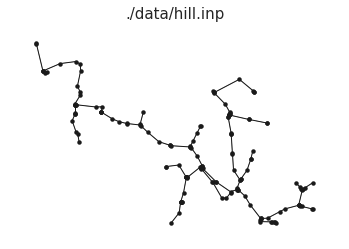

In [2]:
# Create a water network model
inp_file = './data/hill.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.minimum_pressure = 3.5
wn.options.hydraulic.required_pressure = 21

wntr.graphics.plot_network(wn, title=wn.name)

In [3]:
from scripts.bundle_analysis import *
from scripts.plot_utils import *

nname2nid = {}
nid2nname = {}
nid2lid = {}

for nid,nname in enumerate(wn.node_name_list):
    nname2nid[nname] = nid
    nid2nname[nid] = nname
    nid2lid[nid] = []
    
lid2nids = {}
lname2lid = {}
lid2lname = {}


for lid,pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    n1_name = pipe.start_node_name
    n2_name = pipe.end_node_name
    lname2lid[pipe.name] = lid
    lid2lname[lid] = pipe.name
    
    nid1,nid2 = nname2nid[n1_name],nname2nid[n2_name]
    lid2nids[lid] = (nid1,nid2)
    
    nid2lid[nid1].append(lid)
    nid2lid[nid2].append(lid)
    
pids = list(lid2lname.keys())
src_pids = [lname2lid['P11']]
valid_pids = list(set(pids)-set(src_pids))

idx2pid = {}
pid2idx = {}
for i,pid in enumerate(valid_pids):
    idx2pid[i] = pid
    pid2idx[pid] = i
    
pipe_adj_mtx = assemble_pipe_adj_mtx(nid2lid)
pipe_data = get_pipe_df(wn)

# Recursively remove pipe bundles to evaluate isolation impacts

In [4]:
required_numbers = list(range(1,10))
demand_impacts = []
pbundles,nbundles = [], []


for required_number in required_numbers:
    pipe_bundles,node_bundles = get_bundles(valid_pids,pipe_adj_mtx,
                                            required_number,src_pids,lid2nids,lid2lname,nid2nname)
    pbundles.append(pipe_bundles)
    nbundles.append(node_bundles)
    
    impact = bundle_analysis(wn,pipe_bundles,node_bundles,lname2lid,nname2nid,lid2nids,mode = 'demand')
    demand_impacts.append(impact)

# save_progress(demand_impacts,'./data/demand_impacts_hill.txt')
# save_progress(pbundles,'./data/pbundles_hill.txt')
# save_progress(nbundles,'./data/nbundles_hill.txt')


/home/rewu/Documents/research/valves/scripts/bundle_analysis.py:122: RuntimeWarning: invalid value encountered in true_divide
  val_diff_ratio = val_diff/init_val*100


Issues when running hydrualic simulation, use the initial result


# Analyze the result

In [5]:
def get_indirect_losses(impact):
    losses = []
    for ploss in impact:
        losses.append(ploss['indirect_loss'])
    return np.array(losses)

## Average indirect loss (per pipe) 

In [6]:
indirect_losses_list = []
tot_indirect_losses = []
ave_indirect_losses = []
ave_indirect_losses_list = []
num_indirect_pipes = []
first_terms = []
for i,n in enumerate(required_numbers):
    impact = demand_impacts[i]
    indirect_losses = get_indirect_losses(impact)
    indirect_losses_list.append(indirect_losses)
    
    num_indirect = sum(indirect_losses>0)
    num_indirect_pipes.append(num_indirect)
    tot_losses = sum(indirect_losses)
    
    tot_indirect_losses.append(tot_losses)
    ave_loss = tot_losses/(len(pids)*n)
    ave_indirect_losses.append(ave_loss)
    ave_indirect_losses_list.append(indirect_losses/n)
    
    c = len(pids)/n
    first_terms.append(c*ave_loss*n*n/len(pids))
    
    

tot_indirect_losses = np.array(tot_indirect_losses)
ave_indirect_losses = np.array(ave_indirect_losses)

Text(0, 0.5, 'Ave Indirect Loss')

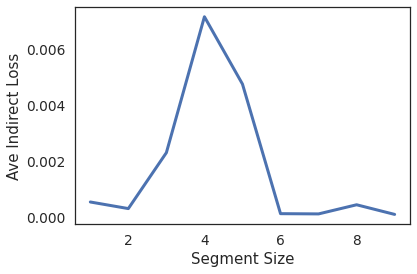

In [7]:
# plt.plot(required_numbers,tot_indirect_losses)
plt.plot(required_numbers,ave_indirect_losses)
plt.xlabel('Segment Size')
plt.ylabel('Ave Indirect Loss')

## Proportion of pipes that cause indirect loss

In [8]:
indirect_pipes_prop = np.array(num_indirect_pipes)/len(pids)*100
no_impact_prop = 100-indirect_pipes_prop

Text(0, 0.5, 'Proportion (%)')

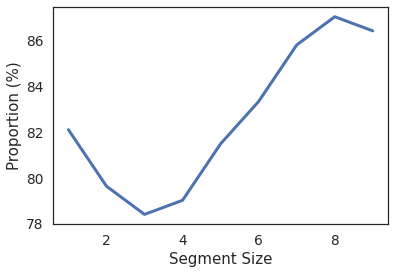

In [9]:
# plt.plot(required_numbers,tot_indirect_losses)
plt.plot(required_numbers,indirect_pipes_prop)
# plt.plot(required_numbers,no_impact_prop)
plt.xlabel('Segment Size')
plt.ylabel('Proportion (%)')

In [10]:
def get_outliers(norm_losses):
    up_quantile = np.quantile(norm_losses, 0.75)
    low_quantile = np.quantile(norm_losses, 0.25)
    mask = norm_losses>(0)
    outlier_idx = [i for i, x in enumerate(mask) if x]
    outliers = norm_losses[mask]
    return outliers,outlier_idx

## Vulnerable pipe map

In [11]:
vital_pnames = []
for ave_loss in ave_indirect_losses_list[:3]:
    pos_mask = ave_loss>0
    pos_idx = np.array([i for i, x in enumerate(pos_mask) if x])
    pos_case = ave_loss[pos_mask]
    
    outliers, outliers_idx = get_outliers(pos_case)
    real_outliers_idx = pos_idx[outliers_idx]
    outliers_pids = [idx2pid[idx] for idx in real_outliers_idx]
    outliers_pnames = [lid2lname[pid] for pid in outliers_pids]
    vital_pnames+=outliers_pnames
vital_pnames = list(set(vital_pnames))
len(vital_pnames)

138

In [12]:
others_pnames = []
for ave_loss in ave_indirect_losses_list[3:]:
    pos_mask = ave_loss>0
    pos_idx = np.array([i for i, x in enumerate(pos_mask) if x])
    pos_case = ave_loss[pos_mask]
    
    outliers, outliers_idx = get_outliers(pos_case)
    real_outliers_idx = pos_idx[outliers_idx]
    outliers_pids = [idx2pid[idx] for idx in real_outliers_idx]
    outliers_pnames = [lid2lname[pid] for pid in outliers_pids]
    others_pnames+=outliers_pnames

others_pnames = list(set(others_pnames))
len(others_pnames)

153

In [13]:
def plot_pipes(p0,p1):

    impact0 = pipe_data[pipe_data['pipe_names'].isin(p0)]
    impact0 = impact0.set_index('pipe_names')
    
    impact1 = pipe_data[pipe_data['pipe_names'].isin(p1)]
    impact1 = impact1.set_index('pipe_names')
    
    ax1 = pipe_data.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 1)
    
    ax1 = impact1.plot(ax= ax1,
                        linewidth=3,
                       color = 'orange',
                       label = 'Second Degree',
                        alpha = 1)
    
    ax1 = impact0.plot(ax= ax1,
                        linewidth=3,
                       label = 'First Degree',
                       color = 'red',
                        alpha = 1)
    

#     ax1 = impact1.plot(ax= ax1,
#                         linewidth=4,
#                        color = 'orange',
#                        label = 'Second Degree',
#                         alpha = 1)
    ax1.legend()
    ax1.axis('off')
#     title = f'''Number of pipes experiencing pressure drop of isolating a pipe with group size {groupsize} '''
#     ax.set_title(title, fontsize=25)
#     plt.savefig("figures_clean/vulnerable_pipes_hill_direct.png",bbox_inches='tight',dpi=300)
    ax1.plot()
    


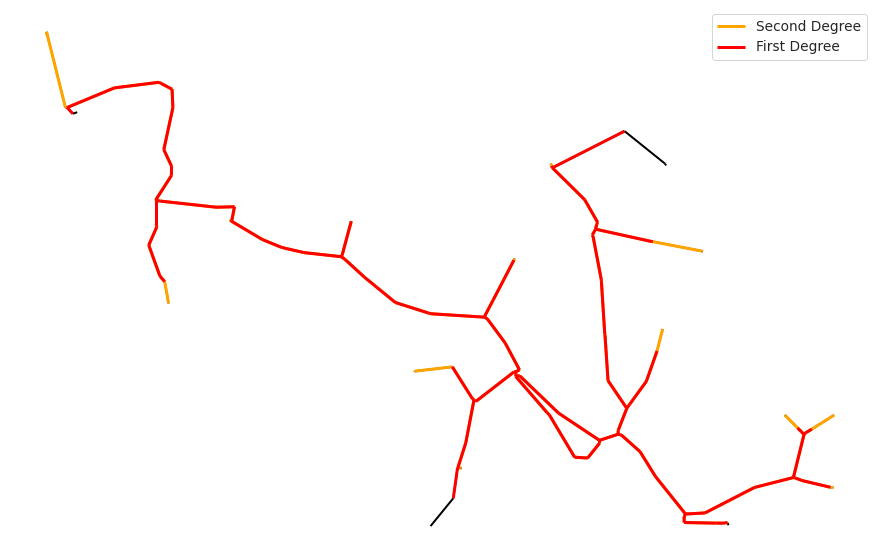

In [14]:
plot_pipes(vital_pnames,others_pnames)